# Targeted protein quantification from list of targets generated in R
needed to use R for peptide-to-protein mapping, jump back here to do quant because it is much faster

In [1]:
from pyteomics import mgf
from pyteomics import mzxml
from pyteomics import mass

import pandas as pd
import numpy as np
import re
import pickle
import timeit
import time

import matplotlib.pyplot as plt
from pylab import rcParams

### Functions to match intensities, m/z, and to get quant frags from the target table

In [2]:
# to extract the int values between two other values
def getFragInt(pred_mass, mz_list, int_list, tol, tol_type):
    ''' 
    PURPOSE:
    Find observed intensity for theoretical m/z value in spectra
    
    INPUTS:
    pred_mass = the theoretical mass of the fragment ion
    mz_array = numpy array of all peak masses in the spectra
    int_array = numpy array of all peak intensities in the spectra
    ppm = the mass tolerance for the fragments in ppm
    noiselevel = value to be subtracted from each value
    
    OUTPUTS:
    numpy array containing the intensity for any m/z found
    
    '''
    if tol_type=="ppm":
        lowmz = pred_mass - pred_mass*tol
        highmz = pred_mass + pred_mass*tol
    if tol_type == "abs":
        lowmz = pred_mass - tol
        highmz = pred_mass + tol
    found = [int_list[index] for index, value in enumerate(mz_list) if value>lowmz and value<highmz]
    #found = found-noiselevel
    if len(found)==0:
        found = [1]
    return(found[0])

In [3]:
# function to get the quant frag table from the line in the target table
def getQuantFragsFromTargetList(target_table, line):
    tmpline = target_table.iloc[line]
    if(len(tmpline['ylight'])>1):
        output= pd.DataFrame( {'lightmz':[float(x) for x in tmpline['ylight']], 
                   'heavymz':[float(x) for x in tmpline['yheavy']]})
    if(len(tmpline['ylight'])<2):
        print(str(tmpline['Peptide'])+'not enough fragments')
        output = 'not enough fragments'
    return(output)

# For most intense peptide set - need to match peptide targets to scans

### Import the quant target table from R

In [5]:
qtargs2 = pd.read_csv("Data/Input/jesse/mostintense_quantmzlist.txt", sep="\t",
                          converters={"ylight": lambda x: x.strip("[]").split(", "),
                                     "yheavy": lambda x: x.strip("[]").split(", "), 
                                     "yordinals": lambda x: x.strip("[]").split(", ")}) # (I can't find an instance where this is used?)
qtargs2

,Peptide,prec_light_mz,prec_heavy_mz,z,scan,ylight,yheavy,yordinals,CV
0,A+42.01057ESDWDTVTVLRK,781.40,790.41,2,1,"[616.4141, 931.5571, 816.5302]","[634.4365, 949.5796, 834.5526]","[5, 8, 7]",-30
1,TIAEC+57.0215LADELINAAK,816.42,820.43,2,2,"[944.5047, 403.23, 1057.5888]","[952.5189, 411.2442, 1065.603]","[9, 4, 10]",-30
2,VLVSGLPPSGSWQDLK,841.96,845.97,2,3,"[1114.5527, 1017.5, 260.1969]","[1122.5669, 1025.5142, 268.2111]","[10, 9, 2]",-30
3,TLFSNIVLSGGSTLFK,842.47,846.48,2,4,"[1008.5724, 909.504, 796.4199]","[1016.5866, 917.5182, 804.4341]","[10, 9, 8]",-30
4,GTQGVVTNFEIFR,734.39,739.39,2,5,"[1025.5415, 926.473, 1181.6313]","[1035.5497, 936.4813, 1191.6396]","[8, 7, 10]",-30
...,...,...,...,...,...,...,...,...,...
547,VTLRLDTHPAMVTVLEMGAAR,761.08,767.75,3,548,"[947.4979, 747.3818, 505.2551]","[957.5061, 757.3901, 515.2634]","[9, 7, 5]",-80
548,ALSQRDPPHNNFFFFDGMK,756.69,762.70,3,549,"[335.1748, 450.2017, 597.2701]","[343.189, 458.2159, 605.2843]","[3, 4, 5]",-80
549,HQNVQLPREGQEDQGLTK,693.02,699.03,3,550,"[546.3246, 975.4742, 790.3941]","[554.3388, 983.4884, 798.4083]","[5, 9, 7]",-80
550,A+42.01057VPETRPNHTIYINNLNEK,755.73,761.74,3,551,"[1007.5156, 731.3682, 390.1983]","[1015.5298, 739.3824, 398.2125]","[8, 6, 3]",-80


In [6]:
target_scan_ids = [(qtargs2['prec_light_mz'][x], qtargs2['prec_heavy_mz'][x], qtargs2['CV'][x]) for x in range(len(qtargs2))]
target_scan_ids

[(781.4, 790.41, -30),
 (816.42, 820.43, -30),
 (841.96, 845.97, -30),
 (842.47, 846.48, -30),
 (734.39, 739.39, -30),
 (776.94, 781.94, -30),
 (822.97, 826.98, -30),
 (733.85, 737.86, -30),
 (851.95, 855.96, -30),
 (851.92, 856.92, -30),
 (803.42, 808.42, -30),
 (911.41, 915.42, -30),
 (940.43, 944.44, -30),
 (940.05, 944.06, -30),
 (714.9, 718.91, -30),
 (554.29, 558.3, -30),
 (733.93, 742.94, -30),
 (779.08, 782.42, -30),
 (642.33, 646.34, -30),
 (642.86, 647.86, -30),
 (643.31, 648.31, -30),
 (748.86, 752.87, -30),
 (784.44, 789.44, -30),
 (818.99, 823.0, -30),
 (934.48, 938.49, -30),
 (817.93, 821.94, -30),
 (717.93, 721.94, -30),
 (838.93, 842.94, -30),
 (839.48, 843.49, -30),
 (793.41, 798.41, -30),
 (684.91, 689.91, -30),
 (564.33, 568.34, -30),
 (650.36, 655.36, -30),
 (616.85, 620.86, -30),
 (676.38, 680.39, -30),
 (579.35, 583.36, -30),
 (620.82, 625.82, -30),
 (721.38, 730.39, -30),
 (691.32, 695.33, -30),
 (740.4, 744.41, -30),
 (666.38, 675.39, -30),
 (766.41, 771.41, -30

In [512]:
len(target_scan_ids)

552

In [8]:
### makes a dict of scan:CV value pairs for lookup of the CV
tmp_prec_dict = {}
with mzxml.read("Data/Input/jesse/20190503_DI2A_tMS2_OTmostint_A549_1to1_01.mzXML") as spectra:
    for x in spectra:
        tmp_prec_dict[round(x['precursorMz'][0]['precursorMz'], 2), 
                                   round(x['precursorMz'][1]['precursorMz'], 2), 
                                  x['compensationVoltage']] = x['num']
tmp_prec_dict

{(781.4, 790.41, -30.0): '1',
 (816.42, 820.43, -30.0): '2',
 (841.96, 845.97, -30.0): '3',
 (842.47, 846.48, -30.0): '4',
 (734.39, 739.39, -30.0): '5',
 (776.94, 781.94, -30.0): '6',
 (822.97, 826.98, -30.0): '7',
 (733.85, 737.86, -30.0): '8',
 (851.95, 855.96, -30.0): '9',
 (851.92, 856.92, -30.0): '10',
 (803.42, 808.42, -30.0): '11',
 (911.41, 915.42, -30.0): '12',
 (940.43, 944.44, -30.0): '13',
 (940.05, 944.06, -30.0): '14',
 (714.9, 718.91, -30.0): '15',
 (554.29, 558.3, -30.0): '16',
 (733.93, 742.94, -30.0): '17',
 (779.08, 782.42, -30.0): '18',
 (642.33, 646.34, -30.0): '19',
 (642.86, 647.86, -30.0): '20',
 (643.31, 648.31, -30.0): '21',
 (748.86, 752.87, -30.0): '22',
 (784.44, 789.44, -30.0): '23',
 (818.99, 823.0, -30.0): '24',
 (934.48, 938.49, -30.0): '25',
 (817.93, 821.94, -30.0): '26',
 (800.45, 808.46, -30.0): '27',
 (717.93, 721.94, -30.0): '28',
 (925.46, 929.47, -30.0): '29',
 (838.93, 842.94, -30.0): '30',
 (839.48, 843.49, -30.0): '31',
 (793.41, 798.41, -30

In [10]:
## fix the numbering of which scan each peptide should be quantified from because the table has decoys left in it
quant_scan = []
for x in target_scan_ids:
    quant_scan.append(tmp_prec_dict[(x)])
qtargs2['quantscan'] = quant_scan
qtargs2

,Peptide,prec_light_mz,prec_heavy_mz,z,scan,ylight,yheavy,yordinals,CV,quantscan
0,A+42.01057ESDWDTVTVLRK,781.40,790.41,2,1,"[616.4141, 931.5571, 816.5302]","[634.4365, 949.5796, 834.5526]","[5, 8, 7]",-30,1
1,TIAEC+57.0215LADELINAAK,816.42,820.43,2,2,"[944.5047, 403.23, 1057.5888]","[952.5189, 411.2442, 1065.603]","[9, 4, 10]",-30,2
2,VLVSGLPPSGSWQDLK,841.96,845.97,2,3,"[1114.5527, 1017.5, 260.1969]","[1122.5669, 1025.5142, 268.2111]","[10, 9, 2]",-30,3
3,TLFSNIVLSGGSTLFK,842.47,846.48,2,4,"[1008.5724, 909.504, 796.4199]","[1016.5866, 917.5182, 804.4341]","[10, 9, 8]",-30,4
4,GTQGVVTNFEIFR,734.39,739.39,2,5,"[1025.5415, 926.473, 1181.6313]","[1035.5497, 936.4813, 1191.6396]","[8, 7, 10]",-30,5
...,...,...,...,...,...,...,...,...,...,...
547,VTLRLDTHPAMVTVLEMGAAR,761.08,767.75,3,548,"[947.4979, 747.3818, 505.2551]","[957.5061, 757.3901, 515.2634]","[9, 7, 5]",-80,561
548,ALSQRDPPHNNFFFFDGMK,756.69,762.70,3,549,"[335.1748, 450.2017, 597.2701]","[343.189, 458.2159, 605.2843]","[3, 4, 5]",-80,562
549,HQNVQLPREGQEDQGLTK,693.02,699.03,3,550,"[546.3246, 975.4742, 790.3941]","[554.3388, 983.4884, 798.4083]","[5, 9, 7]",-80,563
550,A+42.01057VPETRPNHTIYINNLNEK,755.73,761.74,3,551,"[1007.5156, 731.3682, 390.1983]","[1015.5298, 739.3824, 398.2125]","[8, 6, 3]",-80,564


In [11]:
fileslist = [
    "Data/Input/jesse/20190503_DI2A_tMS2_OTmostint_A549_1to8_01.mzXML",
    "Data/Input/jesse/20190503_DI2A_tMS2_OTmostint_A549_1to4_01.mzXML",
    "Data/Input/jesse/20190503_DI2A_tMS2_OTmostint_A549_1to2_01.mzXML",
    "Data/Input/jesse/20190503_DI2A_tMS2_OTmostint_A549_1to1_01.mzXML",
    "Data/Input/jesse/20190503_DI2A_tMS2_OTmostint_A549_2to1_01.mzXML",
    "Data/Input/jesse/20190503_DI2A_tMS2_OTmostint_A549_4to1_01.mzXML",
    "Data/Input/jesse/20190503_DI2A_tMS2_OTmostint_A549_8to1_01.mzXML"
]

## Use fragments from qtargs2

In [12]:
resultsdict = {}
stt = time.time()
TOL_TYPE = "ppm"
TOL = 10e-6

for k in fileslist: #for each of the DISPA files (why so many?)
    meanratio_list = []
    medianratio_list= []
    matchdf_list = []
    quantscans = qtargs2['quantscan'] # a list of the scan numbers, excluding decoys (can I exclude those in advance?)
    with mzxml.read(k, use_index =True) as tmpquantfile:
        #quantscans = sortedpepdf['quantscans'].tolist()
        peplist = qtargs2['Peptide'].tolist() # a list of the Peptides (why don't you do this before the for loop?)
        #specnamelist = sortedpepdf['Name'].tolist()
        looplen = len(qtargs2) # Number of peptide targets
        st = time.time()
        for i in range(0, looplen):
            #print(i)
            #sts = time.time()
            tmp_qf = getQuantFragsFromTargetList(qtargs2, i)
            #tmp_qf:
            # if # ions 0 or 1, prints, tmp_qf is a string
            # else it's a dataframe with two columns, light and heavy ion mz values
            if(type(tmp_qf)!=str):
                tmpmzarray = tmpquantfile.get_by_id(quantscans[i])['m/z array'].tolist() # get's the mz array of corresponding value from the mzxml file
                tmpintarray = tmpquantfile.get_by_id(quantscans[i])['intensity array'].tolist() # same, but intensities
                lightints = [getFragInt(x, tmpmzarray, tmpintarray, TOL, TOL_TYPE) for x in tmp_qf['lightmz']] # finds a matching peak in our data, intensity value added to list
                heavyints = [getFragInt(x, tmpmzarray, tmpintarray, TOL, TOL_TYPE) for x in tmp_qf['heavymz']] # finds a matching peak in our data, intensity value added to list
                ratios = [x/y for x,y in zip(heavyints, lightints)] # calculates ratio of light:heavy for each match
                # note: x and y = 1 if no match was found. (But can't one be found and the other not?)
                tmp_qf['lightint'] = lightints
                tmp_qf['heavyint'] = heavyints
                tmp_qf['HLratios'] = ratios
                matchdf_list.append(tmp_qf) # everything added to the DF, DF added to list
                
                intsum = [sum(x) for x in zip(heavyints, lightints)] # combining intensities of light and heavy
                rm = [index for index, value in enumerate(intsum) if value==2] # get index of values that are both 1 (implying neither night nor heavy matched)
                for x in sorted(rm, reverse=True): # get rid of them
                    del lightints[x]
                    del heavyints[x]
                rm0ratios = [x/y for x,y in zip(heavyints, lightints)] #ratios again, but with the others removed
                # if there is at least one fragment matched, compute ratio and append to lists
                if len(rm0ratios)>0:
                    meanratio_list.append(np.mean(rm0ratios)) # mean ratio added (index corresponds to our quant list)
                    medianratio_list.append(np.median(rm0ratios)) # median ratio added (index corresponds to our quant list)
                #print('time for 1 spec= '+str(time.time()-sts))
        print('file= '+k+', quantified '+str(looplen/(time.time()-st))+' spectra per second')
    resultsdict[k] = [matchdf_list, medianratio_list, meanratio_list] # all results added to dictionary
print(time.time()-stt)

GLGLSPDLIVC+57.0215Rnot enough fragments
DIALVQQLFEALC+57.0215Knot enough fragments
LTAQEAC+57.0215GKnot enough fragments
EASIC+57.0215ALRnot enough fragments
file= Data/Input/jesse/20190503_DI2A_tMS2_OTmostint_A549_1to8_01.mzXML, quantified 111.6935433068587 spectra per second
GLGLSPDLIVC+57.0215Rnot enough fragments
DIALVQQLFEALC+57.0215Knot enough fragments
LTAQEAC+57.0215GKnot enough fragments
EASIC+57.0215ALRnot enough fragments
file= Data/Input/jesse/20190503_DI2A_tMS2_OTmostint_A549_1to4_01.mzXML, quantified 137.25562057466226 spectra per second
GLGLSPDLIVC+57.0215Rnot enough fragments
DIALVQQLFEALC+57.0215Knot enough fragments
LTAQEAC+57.0215GKnot enough fragments
EASIC+57.0215ALRnot enough fragments
file= Data/Input/jesse/20190503_DI2A_tMS2_OTmostint_A549_1to2_01.mzXML, quantified 138.1369248068057 spectra per second
GLGLSPDLIVC+57.0215Rnot enough fragments
DIALVQQLFEALC+57.0215Knot enough fragments
LTAQEAC+57.0215GKnot enough fragments
EASIC+57.0215ALRnot enough fragments
fil

In [517]:
allmedians = []
allmeans = []
for x in fileslist: # all means/medians appended - specifically the log base 2 values - to a new list 
    tmpmedians = resultsdict[x][1]
    tmpmeans = resultsdict[x][2]
    allmedians.append([np.log2(x) for x in tmpmedians if type(x) != list ])
    allmeans.append([np.log2(x) for x in tmpmeans if type(x) != list ])
print('number of peptides (proteins) quantified')
for x in allmedians:
    print(len(x))
    
# I feel like I reached the end of a book and the last chapter is missing. What do we do with these values? What is the final format for "quantification?" Molar?

number of peptides (proteins) quantified
525
511
501
490
497
500
486


In [518]:
allmedianslonglist = []
allmeanslonglist = []
for x in fileslist:
    tmpmedians = resultsdict[x][1] #non-log base 2 values
    tmpmeans = resultsdict[x][2] #non-log base 2 values
    #tmpval[np.log2(y) for y in tmpmedians if type(y) != list ] 
    allmedianslonglist = allmedianslonglist + [np.log2(y) for y in tmpmedians if type(y) != list ] # puts all into one list instead, not list of lists
    allmeanslonglist = allmeanslonglist + [np.log2(y) for y in tmpmeans if type(y) != list ]
i=1
xvals = []
for x in allmedians:
    xvals = xvals +[i]*len(x)
    i+=1

# Make figure 3 panel C

(-13, 13)

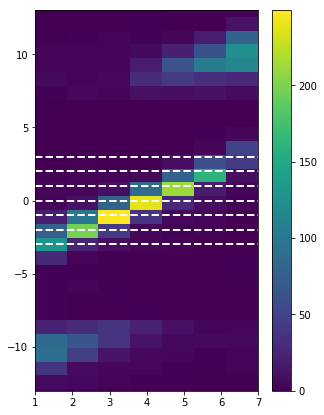

In [520]:
rcParams['figure.figsize'] = 5, 7
fig, ax = plt.subplots()

h = ax.hist2d(np.array(xvals), np.asarray(allmedianslonglist), bins=[7,31], )
#plt.ylim(-6,6)
plt.colorbar(h[3], ax=ax)
plt.plot([1,7], [np.log2(8/1), np.log2(8/1)], color='w', linestyle='--', linewidth=2)
plt.plot([1,7], [np.log2(4/1), np.log2(4/1)], color='w', linestyle='--', linewidth=2)
plt.plot([1,7], [np.log2(2/1), np.log2(2/1)], color='w', linestyle='--', linewidth=2)
plt.plot([1,7], [np.log2(1/1), np.log2(1/1)], color='w', linestyle='--', linewidth=2)
plt.plot([1,7], [np.log2(1/2), np.log2(1/2)], color='w', linestyle='--', linewidth=2)
plt.plot([1,7], [np.log2(1/4), np.log2(1/4)], color='w', linestyle='--', linewidth=2)
plt.plot([1,7], [np.log2(1/8), np.log2(1/8)], color='w', linestyle='--', linewidth=2)
plt.ylim(-13,13)
#plt.savefig('P:/JGM_DI2A/Python/outputs/heatmap10ppm_top3_1_ion.svg', type='svg')
#plt.xlabel(['8:1', '4:1', '2:1'])
#plt.title('20ppm, at least one ion from top3')